## How to access this in Colab
본 실습에서는 모델 학습 단에서 DICOM원본을 받기에는 용량에 한계가 있어, PNG파일을 활용합니다.
1. 개인 google drive에 폴더를 생성해주세요.
2. 이 ipynb 파일과 아래 링크에서 data, dense_ckpt01 폴더를 받아서 같은 디렉토리에 저장해주세요.  
https://drive.google.com/drive/folders/19QLnvMjG4iAbvxq7s3xjYD43keN6kHzK?usp=sharing

In [ ]:
!pip install pytorch

In [ ]:
!pip install grad-cam

In [ ]:
!pip install ttach

---

# RSNA Intracranial Hemorrhage Detection
In this competition, your challenge is to build an algorithm to detect acute intracranial hemorrhage and its subtypes.

## Intracranial hemorrhage

![subtype](./sample/subtypes-of-hemorrhage.png)

본 실습에서는 kaggle의 'RSNA Intracranial Hemorrhage Detection' challenge의 `Brain CT 데이터셋`을 활용하여  
`CT의 각 slice를 Intracranial Hemorrhage의 총 5가지 subtype으로 분류하는 classification model` 구축을 진행합니다. 

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader, Dataset

import os
import numpy as np
import pydicom
from PIL import Image
import matplotlib.pyplot as plt
import time
import copy
from tqdm import tqdm
import pickle
from sklearn import metrics
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sn

print(torch.__version__)

1.8.0.dev20201207+cu101


## How to access this dataset?
본 실습에서는 모델 학습 단에서 DICOM원본을 받기에는 용량에 한계가 있어, PNG파일을 활용합니다.

In [10]:
FILE_EXTENSION = ['.img', '.IMG', '.jpg', '.JPG', '.jpeg', '.JPEG', '.png', \
                  '.PNG', '.gif', '.GIF', 'dcm', 'DCM', '.csv', '.CSV']
DCM_EXTENSION = ['.dcm', '.DCM']
IMG_EXTENSION = ['.img', '.IMG', '.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG', '.gif', '.GIF']
PNG_EXTENSION = ['.png', '.PNG']

def check_extension(filename, extension_ls=FILE_EXTENSION):
    # filename이 해당 확장자(extension_ls)로 되어있는 경우 True
    return any(filename.endswith(extension) for extension in extension_ls)

def load_file_paths(folder_path, extension_ls=FILE_EXTENSION):
    """
    find 'extension_ls' file paths in folder.
    
    Parameters:
        folder_path (str) -- folder directory
        extension_ls (list) -- list of extensions
    
    Return:
        file_paths (list) -- list of 'extension_ls' file paths
    
    """
    
    file_paths = []
    assert os.path.isdir(folder_path), f'{folder_path} is not a valid directory'

    for root, _, fnames in sorted(os.walk(folder_path)):
        for fname in fnames:
            if check_extension(fname, extension_ls):
                path = os.path.join(root, fname)
                file_paths.append(path)
 
    return file_paths[:]

In [11]:
def set_outside_scanner_to_air(hu_pixelarrays):
    """
    Pixel Padding Value Attribute(0028,0120) -> air
    """
    hu_pixelarrays[hu_pixelarrays < -1024] = -1024
    
    return hu_pixelarrays

In [12]:
def transform_to_hu(dicom_info, image):
    image = set_outside_scanner_to_air(image)
    
    intercept = dicom_info.RescaleIntercept
    slope = dicom_info.RescaleSlope
    hu_image = image.astype(np.float64) * slope + intercept
    hu_image = set_outside_scanner_to_air(hu_image.astype(np.int16))
    return hu_image

In [13]:
def ct_img_loader(dcm_path):
    """
    Function of Loading CT-scan
    patient path to CT slices(HU)
    
    Parameters:
        dcm_path (str) -- dicom file path
    
    Return:
        dcm_img (np.array) -- CT slice(HU)
    """
    # force=True : reading even if no File Meta Information header is found
    dcm_info = pydicom.read_file(dcm_path, force=True)
    tmp_img = dcm_info.pixel_array
    dcm_img = transform_to_hu(dcm_info, tmp_img)
    
    return dcm_img

In [14]:
class CT_Windowing:
    """
    CT image windowing : WL_Window Level, WW_Window Width
    """
   
    def __init__(self, mode='custom', custom_window=None, norm=False):
        """
        Parameters:
            mode (str)(WL|WW) -- 
                'abdomen'(60|400) , 'bone'(300|1500), 'brain'(40|80), 
                'chest'(40|400), 'lung'(-700|1500), 'custom'(WL|WW)
            custom_window (list or tuple) -- 
                if mode == 'custom', set custom_window(WL, WW)
            norm (bool) -- normalize to uint8 (0~255)

        """
        option = ['abdomen' , 'bone', 'brain', 'chest', 'lung', 'subdural', 'custom']
        assert mode in option, "Wrong mode: Enter \'abdomen\' , \'bone\', \
                                \'brain\', \'chest\', \'lung\', \'subdural\', \'custom\'"
        
        self.mode = "window_" + mode
        if custom_window is not None:
            self.w_level = custom_window[0]
            self.w_width = custom_window[1]
            
        self.norm = norm
        
    def windowing(self):
        self.w_min = self.w_level - (self.w_width / 2)
        self.w_max = self.w_level + (self.w_width / 2)
        window_image = self.img.copy()
        window_image[window_image < self.w_min] = self.w_min
        window_image[window_image > self.w_max] = self.w_max
        
        if self.norm:
            window_image = np.uint8(((window_image - self.w_min) / \
                                     (self.w_max - self.w_min)) * 255.0)
        return window_image
        
    def window_abdomen(self):
        self.w_level = 60
        self.w_width = 400
        
        return self.windowing()
        
    def window_bone(self):
        self.w_level = 300
        self.w_width = 1500
        
        return self.windowing()
    
    def window_brain(self):
        self.w_level = 40
        self.w_width = 80
        
        return self.windowing()
    
    def window_chest(self):
        self.w_level = 40
        self.w_width = 400
        
        return self.windowing()
        
    def window_lung(self):
        #SNUH version
        self.w_level = -700
        self.w_width = 1500
        
        return self.windowing()
    
    def window_subdural(self):
        # RSNA Intrracranial Hemorrhage : See like a Radiologist with Systematic Windowing
        # https://www.kaggle.com/dcstang/see-like-a-radiologist-with-systematic-windowing
        self.w_level = 80
        self.w_width = 200
        
        return self.windowing()
        
    def window_custom(self):
        return self.windowing()
    
    def __call__(self, hu_img):
        self.img = hu_img
        self.opt = getattr(self, self.mode, lambda:'custom')
        return self.opt()  

# Build Classification Model

<a id='hemo_image'></a> 
## Data pipeline: working with DICOM files and csv files
학습을 위한 데이터셋을 만들기 위해 label(.csv)과 data(.dcm)을 매칭해줍니다.  
실습의 편의를 위해 DICOM파일은 CT를 brain window setting에 맞게 windowing한 PNG 이미지 파일로 대체하였습니다.  
실습에서 다루는 데이터는 2000장의 CT slices로 원본 데이터보다 매우 적습니다.  
원본데이터 다운로드는 아래의 링크를 참고하세요.  
https://www.kaggle.com/c/rsna-intracranial-hemorrhage-detection

In [15]:
#원본 데이터를 사용할 경우 TRAIN_PATH = "./data/rsna-intracranial-hemorrhage-detection/stage_2_train"
TRAIN_PATH = "./data/rsna-intracranial-hemorrhage-detection/data_png"

#DCM file path 추출
train_img_paths = load_file_paths(TRAIN_PATH, PNG_EXTENSION) #DCM_EXTENSION
#label DataFrame
new_train_label_df = pd.read_csv("./data/rsna-intracranial-hemorrhage-detection/new_train_label.csv")
new_train_label_df.tail()

,id,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
752798,ID_ffff82e46,0,0,0,0,0,0
752799,ID_ffff922b9,1,0,0,1,0,0
752800,ID_ffffb670a,1,0,0,0,1,0
752801,ID_ffffcbff8,0,0,0,0,0,0
752802,ID_fffff9393,0,0,0,0,0,0


In [16]:
# img_path에서 파일명만 추출
train_img_id = [os.path.splitext(os.path.basename(p))[0] for p in train_img_paths]

In [17]:
# DataFrame에서 DCM file이 있는 id만 추출
sampled_train_df = new_train_label_df[new_train_label_df["id"].isin(train_img_id)].reset_index(drop=True)
sampled_train_df.tail()

,id,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
1995,ID_ff2331a53,0,0,0,0,0,0
1996,ID_ff32b572e,0,0,0,0,0,0
1997,ID_ff5830026,0,0,0,0,0,0
1998,ID_ff67f5cd8,1,0,0,1,0,0
1999,ID_ffff73ede,0,0,0,0,0,0


In [18]:
#label 과 dcm path 매치
sampled_train_df['dcm_path'] = TRAIN_PATH + '/' + sampled_train_df['id'].values + '.png' #".dcm"
sampled_train_df.tail()

,id,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,dcm_path
1995,ID_ff2331a53,0,0,0,0,0,0,./data/rsna-intracranial-hemorrhage-detection/...
1996,ID_ff32b572e,0,0,0,0,0,0,./data/rsna-intracranial-hemorrhage-detection/...
1997,ID_ff5830026,0,0,0,0,0,0,./data/rsna-intracranial-hemorrhage-detection/...
1998,ID_ff67f5cd8,1,0,0,1,0,0,./data/rsna-intracranial-hemorrhage-detection/...
1999,ID_ffff73ede,0,0,0,0,0,0,./data/rsna-intracranial-hemorrhage-detection/...


### Data split ~ train | validation | test
편의를 위해 dataset을 random sampling하였습니다.  
추후 연구를 위해서 case별로 sampling하는 것을 강권합니다.

In [19]:
# Data split (train | validation | test) ~ Randomsplit

In [20]:
# 정상군과 비정상군의 데이터 비율을 확인
normal_train_df = sampled_train_df[sampled_train_df["any"]==0].reset_index(drop=True)
abnormal_train_df = sampled_train_df[sampled_train_df["any"]==1].reset_index(drop=True)
print("정상군 데이터 개수: {}, 비정상군 데이터 개수: {}".format(len(normal_train_df), len(abnormal_train_df)))

정상군 데이터 개수: 1014, 비정상군 데이터 개수: 986


In [21]:
# 학습의 편의를 위해 정상군 데이터는 107933개만 사용
np.random.seed(50)
part_normal_train_df=normal_train_df.iloc[np.random.permutation(normal_train_df.index)].reset_index(drop=True).iloc[:107933]
part_sample_train_df=pd.concat([part_normal_train_df,abnormal_train_df]).reset_index(drop=True)

In [22]:
# 5개의 subtype과 dcm_path를 np.array로 추출
CLASS_NAME = ["epidural", "intraparenchymal", "intraventricular", "subarachnoid", "subdural"]
dataset_arr = part_sample_train_df[["dcm_path"]+CLASS_NAME].values

In [23]:
# split train dataset -> [train, val, internal test] (2:1:1)
seed = 37
part_x_dataset = dataset_arr[:,0]
part_y_dataset = dataset_arr[:,1:]
#stratify_label = sampled_train_df["any"].values

# train : val+test = 6:4
# stratify를 사용하면 label의 비율을 유지할 수 있습니다.
# 정상군과 비정상군의 label 비율을 유지하도록 하였습니다.
x_tr, x_val_tst, y_tr, y_val_tst = train_test_split(part_x_dataset, part_y_dataset, test_size=0.5, shuffle=True, random_state=seed)#stratify=part_y_dataset
# val : test = 1:1
x_val, x_tst, y_val, y_tst = train_test_split(x_val_tst, y_val_tst, test_size=0.5, shuffle=True, random_state=seed) #stratify=y_val_tst

In [24]:
dataset_tr = np.hstack([x_tr[:,np.newaxis], y_tr])
dataset_val = np.hstack([x_val[:,np.newaxis], y_val])
dataset_tst = np.hstack([x_tst[:,np.newaxis], y_tst])

In [25]:
print("train dataset total: \t\t{} \n \
ratio of epidural : \t\t{} \n \
ratio of intraparenchymal : \t{} \n \
ratio of intraventricular : \t{} \n \
ratio of subarachnoid : \t{} \n \
ratio of subdural : \t\t{}"
.format(len(dataset_tr), np.sum(dataset_tr[:, 1])/len(dataset_tr), 
              np.sum(dataset_tr[:, 2])/len(dataset_tr), 
              np.sum(dataset_tr[:, 3])/len(dataset_tr), 
              np.sum(dataset_tr[:, 4])/len(dataset_tr), 
              np.sum(dataset_tr[:, 5])/len(dataset_tr)))
print("val dataset total: \t\t{} \n \
ratio of epidural : \t\t{} \n \
ratio of intraparenchymal : \t{} \n \
ratio of intraventricular : \t{} \n \
ratio of subarachnoid : \t{} \n \
ratio of subdural : \t\t{}"
.format(len(dataset_val), np.sum(dataset_val[:, 1])/len(dataset_val), 
              np.sum(dataset_val[:, 2])/len(dataset_val), 
              np.sum(dataset_val[:, 3])/len(dataset_val), 
              np.sum(dataset_val[:, 4])/len(dataset_val), 
              np.sum(dataset_val[:, 5])/len(dataset_val)))
print("test dataset total: \t\t{} \n \
ratio of epidural : \t\t{} \n \
ratio of intraparenchymal : \t{} \n \
ratio of intraventricular : \t{} \n \
ratio of subarachnoid : \t{} \n \
ratio of subdural : \t\t{}"
.format(len(dataset_tst), np.sum(dataset_tst[:, 1])/len(dataset_tst), 
              np.sum(dataset_tst[:, 2])/len(dataset_tst), 
              np.sum(dataset_tst[:, 3])/len(dataset_tst), 
              np.sum(dataset_tst[:, 4])/len(dataset_tst), 
              np.sum(dataset_tst[:, 5])/len(dataset_tst)))

train dataset total: 		1000 
 ratio of epidural : 		0.017 
 ratio of intraparenchymal : 	0.152 
 ratio of intraventricular : 	0.115 
 ratio of subarachnoid : 	0.161 
 ratio of subdural : 		0.221
val dataset total: 		500 
 ratio of epidural : 		0.02 
 ratio of intraparenchymal : 	0.182 
 ratio of intraventricular : 	0.118 
 ratio of subarachnoid : 	0.164 
 ratio of subdural : 		0.222
test dataset total: 		500 
 ratio of epidural : 		0.02 
 ratio of intraparenchymal : 	0.16 
 ratio of intraventricular : 	0.124 
 ratio of subarachnoid : 	0.144 
 ratio of subdural : 		0.232


In [26]:
dataset_tr[1]

array(['./data/rsna-intracranial-hemorrhage-detection/data_png/ID_98ca2685e.png',
       0, 0, 0, 0, 0], dtype=object)

In [27]:
def img_loader(img_path):
    return np.array(Image.open(img_path))

In [28]:
sample = img_loader(dataset_tr[5][0])

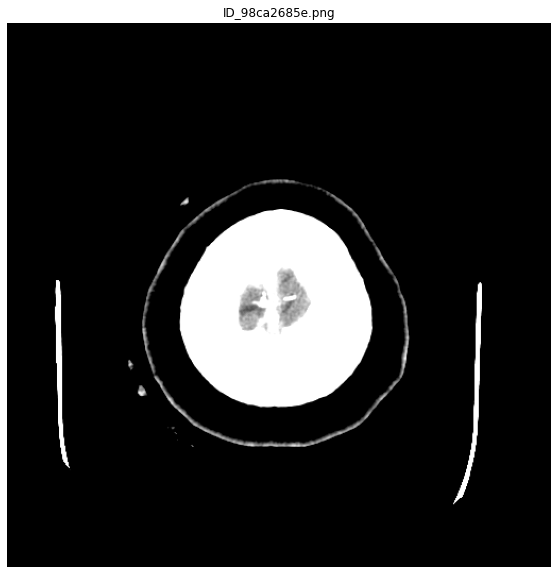

In [29]:
plt.figure(figsize=(10,10))
plt.imshow(sample, cmap='gray')
plt.axis("off")
plt.title(dataset_tr[1][0].split('/')[-1])
plt.show()

## Build dataset
pytorch CustomDataset을 만듭니다.

In [30]:
# input dataset에 대해 brain window로 preprocess를 진행하였습니다. (원본DCM을 이용할 경우 참고하세요)
brain_window_fn = CT_Windowing(mode='brain', norm=True)
def preprocess_fn(hu_image):
    return brain_window_fn(hu_image)

In [31]:
class RSNAHemoDataset(data.Dataset):
    """ data_dir => np.array[[x_dir, y_label]] -> [str, list] """
    def __init__(self, 
                 data_dir, 
                 default_loader = None, #
                 preprocess = None):    #preprocess_fn
        
        self.x_dir = data_dir[:,0]
        self.y_label = data_dir[:,1:]
        self.loader = default_loader
        self.preprocess = preprocess

    def __getitem__(self, index):
        path = self.x_dir[index]
        img = self.loader(path)
        if self.preprocess is not None:
            img = self.preprocess(img)
        self.transform = get_transform()
        if self.transform is not None:
            img = self.transform(img)
        
        label = np.array(self.y_label[index]).astype(float)
        
        sample = img, torch.FloatTensor(label)
        
        return sample
    
    def __len__(self):
        return len(self.x_dir)

In [32]:
def get_transform(params=None, method=Image.BICUBIC, resize=[512, 512], convert=True):
    transform_list = []
    transform_list.append(transforms.ToPILImage())
    #원하는 augmentation method를 추가하면 됩니다.
    #transform_list.append(transforms.RandomAffine((-10, 10)))
    
    if resize:
        transform_list.append(transforms.Resize(resize, method))  
        
    if convert:
        transform_list += [transforms.ToTensor()]
        transform_list += [transforms.Normalize((0.5), (0.5))]
        
    return transforms.Compose(transform_list)

In [33]:
train_dataset = RSNAHemoDataset(dataset_tr, 
                                default_loader = img_loader)

In [34]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16,
                                          shuffle=True, drop_last=True)

In [35]:
dataiter = iter(train_loader)
data1 = dataiter.next()
features, labels = data1
#print(features, labels)

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:256: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [36]:
CLASS_NAME

['epidural',
 'intraparenchymal',
 'intraventricular',
 'subarachnoid',
 'subdural']

In [37]:
# Normalize를 역산하는 function
def inverse_normalization(img, mean_std, grayscale=False):
    tmp = []
    if grayscale:
        return img*mean_std[1][0] + mean_std[0][0]
        
    for l in range(3):
        tmp.append((img[:,:,l]*mean_std[1][l]) + mean_std[0][l])
        
    return np.stack(tmp, axis=-1)

tensor([0., 0., 0., 0., 0.])


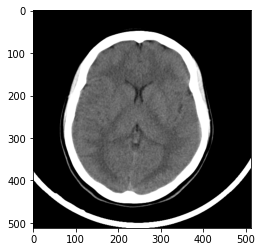

In [38]:
inv_norm_feature = inverse_normalization(features[1].permute(1, 2, 0),[(0.5,), (0.5,)], grayscale=True)
plt.imshow(inv_norm_feature, cmap='gray')
plt.grid(False)
print(labels[1])

## Build classification model: multi-label classification

![multilabel](./sample/multiclass_vs_multilabel.png)

해당 task는 multi-label classification이므로 마지막단에 activation으로 Sigmoid가 채택됩니다.  
본 실습에서는 모델로 DenseNet161을 사용합니다.

<img src="./sample/sigmoid.png" height="200px" width="600px"> <img src="./sample/softmax.jpg" height="200px" width="600px">

reference: 
https://learnopencv.com/multi-label-image-classification-with-pytorch-image-tagging/  
https://towardsdatascience.com/softmax-activation-function-explained-a7e1bc3ad60  
https://medium.com/@toprak.mhmt/activation-functions-for-deep-learning-13d8b9b20e  

In [52]:
# DenseNet
import torchvision.models as models
densenet161 = models.densenet161()
densenet161.features.conv0 = nn.Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
densenet161.classifier = nn.Sequential(nn.Linear(densenet161.classifier.in_features, len(CLASS_NAME)), 
                                       nn.Sigmoid()
                                      )

In [40]:
densenet161

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

## Train

In [53]:
import os
import time
import torch
from torchvision import datasets, transforms

In [54]:
class AverageMeter(object):
    """
    Computes and stores the average and current value
    Copied from: https://github.com/pytorch/examples/blob/master/imagenet/main.py
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [55]:
def train_epoch(model, loader, optimizer, epoch, n_epochs, print_freq=100):
    batch_time = AverageMeter()
    losses = AverageMeter()
    error = AverageMeter()
    
    criterion = torch.nn.BCELoss().cuda() # Loss - Binary Cross-Entropy Loss(BCE Loss)
    # Model on train mode
    model.train()

    end = time.time()
    for batch_idx, (input, target) in enumerate(loader):
        # Create vaiables
        if torch.cuda.is_available():
            input = input.cuda()
            target = target.cuda()

        # compute output
        output = model(input)
        loss = criterion(output, target)

        # measure accuracy and record loss
        batch_size = target.size(0)
        pred = np.round(output.data.cpu().detach())
        error.update(torch.ne(pred, target.cpu()).float().sum().item() / (target.size(1)*batch_size), batch_size)
        losses.update(loss.item(), batch_size)

        # compute gradient and do optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # print stats
        if batch_idx % print_freq == 0:
            res = '\t'.join([
                'Epoch: [%d/%d]' % (epoch + 1, n_epochs),
                'Iter: [%d/%d]' % (batch_idx + 1, len(loader)),
                'Time %.3f (%.3f)' % (batch_time.val, batch_time.avg),
                'Loss %.4f (%.4f)' % (losses.val, losses.avg),
                'Error %.4f (%.4f)' % (error.val, error.avg),
            ])
            print(res)

    # Return summary statistics
    return batch_time.avg, losses.avg, error.avg

In [56]:
def test_epoch(model, loader, print_freq=10, is_test=True):
    batch_time = AverageMeter()
    losses = AverageMeter()
    error = AverageMeter()
    
    criterion = torch.nn.BCELoss().cuda()
    # Model on eval mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for batch_idx, (input, target) in enumerate(loader):
            # Create vaiables
            if torch.cuda.is_available():
                input = input.cuda()
                target = target.cuda()

            # compute output
            output = model(input)
            loss = criterion(output, target)

            # measure accuracy and record loss
            batch_size = target.size(0)
            pred = np.round(output.data.cpu().detach())
            error.update(torch.ne(pred,target.cpu()).float().sum().item() / (target.size(1)*batch_size), batch_size)
            losses.update(loss.item(), batch_size)

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            # print stats
            if batch_idx % print_freq == 0:
                res = '\t'.join([
                    'Test' if is_test else 'Valid',
                    'Iter: [%d/%d]' % (batch_idx + 1, len(loader)),
                    'Time %.3f (%.3f)' % (batch_time.val, batch_time.avg),
                    'Loss %.4f (%.4f)' % (losses.val, losses.avg),
                    'Error %.4f (%.4f)' % (error.val, error.avg),
                ])
                print(res)

    # Return summary statistics
    return batch_time.avg, losses.avg, error.avg

In [57]:
def train(model, train_set, valid_set, test_set, save, n_epochs=300,
          batch_size=64, lr=0.001, save_epoch=10, seed=None):
    cnt=0
    if seed is not None:
        torch.manual_seed(seed)

    # Data loaders
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True,
                                               pin_memory=(torch.cuda.is_available()), num_workers=0)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False,
                                              pin_memory=(torch.cuda.is_available()), num_workers=0)
    if valid_set is None:
        valid_loader = None
    else:
        valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False,
                                                   pin_memory=(torch.cuda.is_available()), num_workers=0)
    # Model on cuda
    if torch.cuda.is_available():
        model = model.cuda()

    # Wrap model for multi-GPUs, if necessary
    model_wrapper = model
    if torch.cuda.is_available() and torch.cuda.device_count() > 1:
        model_wrapper = torch.nn.DataParallel(model).cuda()

    # Optimizer
    optimizer = torch.optim.Adam(model_wrapper.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[0.5 * n_epochs, 0.75 * n_epochs],
                                                     gamma=0.1)

    # Start log
    with open(os.path.join(save, 'results.csv'), 'w') as f:
        f.write('epoch,train_loss,train_error,valid_loss,valid_error,test_error\n')

    # Train model
    best_error = 1
    for epoch in range(n_epochs):
        _, train_loss, train_error = train_epoch(
            model=model_wrapper,
            loader=train_loader,
            optimizer=optimizer,
            epoch=epoch,
            n_epochs=n_epochs,
        )
        scheduler.step()
        _, valid_loss, valid_error = test_epoch(
            model=model_wrapper,
            loader=valid_loader if valid_loader else test_loader,
            is_test=(not valid_loader)
        )

        # Determine if model is the best
        if valid_loader:
            if valid_error < best_error:
                best_error = valid_error
                print('New best error: %.4f' % best_error)
                torch.save(model.state_dict(), os.path.join(save, 'model_epoch'+str(cnt).zfill(3)+'.dat'))
        else:
            if (cnt%save_epoch==0):
                torch.save(model.state_dict(), os.path.join(save, 'model_epoch'+str(cnt).zfill(3)+'.dat'))

        # Log results
        with open(os.path.join(save, 'results.csv'), 'a') as f:
            f.write('%03d,%0.6f,%0.6f,%0.5f,%0.5f,\n' % (
                (epoch + 1),
                train_loss,
                train_error,
                valid_loss,
                valid_error,
            ))
        cnt+=1
    torch.save(model.state_dict(), os.path.join(save, 'model_final.dat'))

    # Final test of model on test set
    model.load_state_dict(torch.load(os.path.join(save, 'model_final.dat')))
    if torch.cuda.is_available() and torch.cuda.device_count() > 1:
        model = torch.nn.DataParallel(model).cuda()
    test_results = test_epoch(
        model=model,
        loader=test_loader,
        is_test=True
    )
    _, _, test_error = test_results
    with open(os.path.join(save, 'results.csv'), 'a') as f:
        f.write(',,,,,%0.5f\n' % (test_error))
    print('Final test error: %.4f' % test_error)

In [58]:
save_path = './demo_ckpt01'

In [59]:
def demo(save, model,
         n_epochs=300, batch_size=64, seed=None):
    """

    """
    # Datasets
    train_dataset = RSNAHemoDataset(dataset_tr, 
                                    default_loader = img_loader)
    val_dataset = RSNAHemoDataset(dataset_val, 
                                  default_loader = img_loader)
    test_dataset = RSNAHemoDataset(dataset_tst, 
                                   default_loader = img_loader)

    # Models
    #print(model)
    
    # Print number of parameters
    num_params = sum(p.numel() for p in model.parameters())
    print("Total parameters: ", num_params)

    # Make save directory
    if not os.path.exists(save):
        os.makedirs(save)
    if not os.path.isdir(save):
        raise Exception('%s is not a dir' % save)

    # Train the model
    train(model=model, train_set=train_dataset, valid_set=val_dataset, test_set=test_dataset, save=save,
          n_epochs=n_epochs, batch_size=batch_size, seed=seed)
    print('Done!')

In [60]:
demo(save_path, densenet161, n_epochs=30, batch_size=8, seed=None)

Total parameters:  26473637
Epoch: [1/30]	Iter: [1/125]	Time 0.432 (0.432)	Loss 0.5787 (0.5787)	Error 0.1750 (0.1750)
Epoch: [1/30]	Iter: [101/125]	Time 0.562 (0.394)	Loss 0.3296 (0.3813)	Error 0.0750 (0.1418)
Valid	Iter: [1/63]	Time 0.122 (0.122)	Loss 0.4487 (0.4487)	Error 0.1750 (0.1750)
Valid	Iter: [11/63]	Time 0.118 (0.121)	Loss 0.2864 (0.3478)	Error 0.0750 (0.1318)
Valid	Iter: [21/63]	Time 0.119 (0.121)	Loss 0.3002 (0.3357)	Error 0.1000 (0.1274)
Valid	Iter: [31/63]	Time 0.125 (0.122)	Loss 0.3178 (0.3521)	Error 0.1250 (0.1323)
Valid	Iter: [41/63]	Time 0.121 (0.127)	Loss 0.2582 (0.3716)	Error 0.0750 (0.1402)
Valid	Iter: [51/63]	Time 0.122 (0.126)	Loss 0.4964 (0.3769)	Error 0.2000 (0.1417)
Valid	Iter: [61/63]	Time 0.120 (0.130)	Loss 0.2958 (0.3780)	Error 0.1000 (0.1426)
New best error: 0.1412
Epoch: [2/30]	Iter: [1/125]	Time 0.384 (0.384)	Loss 0.5540 (0.5540)	Error 0.2250 (0.2250)
Epoch: [2/30]	Iter: [101/125]	Time 0.424 (0.390)	Loss 0.2860 (0.3689)	Error 0.0750 (0.1386)
Valid	Iter: 

In [61]:
from sklearn import metrics

In [62]:
train_history = pd.read_csv('./demo_ckpt01/results.csv')

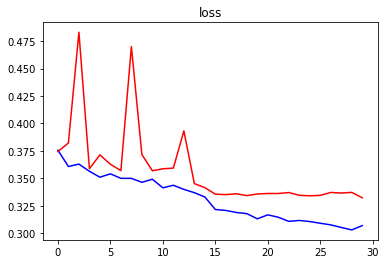

In [63]:
plt.figure()
plt.title('loss')
plt.plot(np.array(train_history['train_loss']), 'b')
plt.plot(np.array(train_history['valid_loss']), 'r')

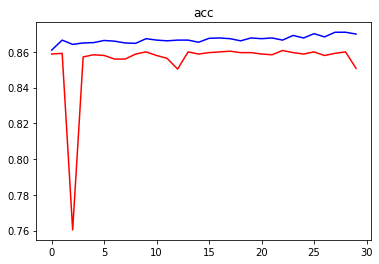

In [64]:
plt.figure()
plt.title('acc')
plt.plot(1-np.array(train_history['train_error']), 'b')
plt.plot(1-np.array(train_history['valid_error']), 'r')

## Validation

In [65]:
save_path = './demo_ckpt01/'
net_pre = models.densenet161()
net_pre.features.conv0 = nn.Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
net_pre.classifier = nn.Sequential(nn.Linear(net_pre.classifier.in_features, 5), nn.Sigmoid())

net_pre.load_state_dict(torch.load(os.path.join(save_path, 'model_epoch022.dat')))

<All keys matched successfully>

In [66]:
# hamming score는 각각의 class에 대해 precision(TP/TP+FP)을 구하고 평균을 구합니다.
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    https://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [67]:
def test_acc(testloader, model, class_num):
    correct = 0
    total = 0
    output_arr = np.ones((1, class_num))
    label_arr = np.ones((1, class_num))
    pred_arr = np.ones((1, class_num))
    if torch.cuda.is_available():
        model.cuda()
    model.eval()
    
   

    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
            outputs = model(images)
            predicted = torch.round(outputs.data)
            
            output_arr = np.concatenate((output_arr, outputs.cpu().numpy()), axis=0)
            label_arr = np.concatenate((label_arr, labels.cpu().numpy()), axis=0)
            pred_arr = np.concatenate((pred_arr, predicted.cpu().numpy()), axis=0)

    output_arr = np.delete(output_arr, 0, axis=0)
    label_arr = np.delete(label_arr, 0, axis=0)
    pred_arr = np.delete(pred_arr, 0, axis=0)
    # multi-label classification은 평가지표가 multi-class classification과는 다르고 다양합니다.
    h_score = hamming_score(label_arr,pred_arr)
    print('Hamming score on the test images: ', h_score)
    
    return h_score, output_arr, label_arr, pred_arr

In [68]:
test_dataset = RSNAHemoDataset(dataset_tst,
                               default_loader = img_loader)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False,
                                          pin_memory=(torch.cuda.is_available()), num_workers=0)

In [70]:
h_score, output_arr, label_arr, pred_arr = test_acc(test_loader, net_pre, class_num=5)

100%|██████████| 32/32 [00:07<00:00,  4.17it/s]

Hamming score on the test images:  0.5203333333333334


In [71]:
CLASS_NAME = ["epidural", "intraparenchymal", "intraventricular", "subarachnoid", "subdural"]
print(metrics.classification_report(label_arr, pred_arr, target_names=CLASS_NAME))

                  precision    recall  f1-score   support

        epidural       0.00      0.00      0.00        10
intraparenchymal       0.33      0.01      0.02        80
intraventricular       0.67      0.06      0.12        62
    subarachnoid       0.00      0.00      0.00        72
        subdural       0.38      0.05      0.09       116

       micro avg       0.44      0.03      0.06       340
       macro avg       0.28      0.03      0.05       340
    weighted avg       0.33      0.03      0.06       340
     samples avg       0.02      0.01      0.01       340



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [72]:
from sklearn.metrics import multilabel_confusion_matrix

In [73]:
#confusion matrix : one vs rest
cm = multilabel_confusion_matrix(label_arr, pred_arr)
cm

array([[[490,   0],
        [ 10,   0]],

       [[418,   2],
        [ 79,   1]],

       [[436,   2],
        [ 58,   4]],

       [[428,   0],
        [ 72,   0]],

       [[374,  10],
        [110,   6]]])

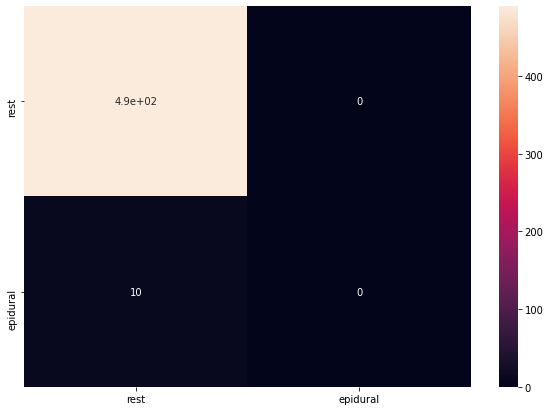

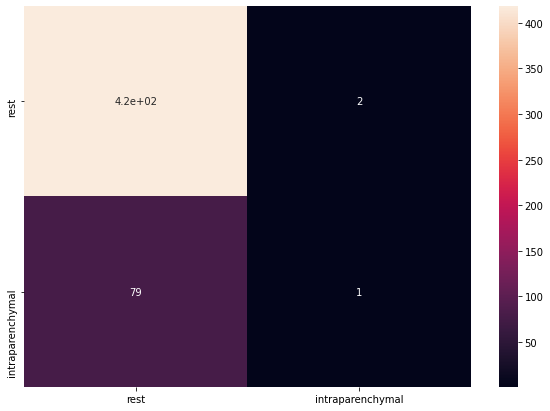

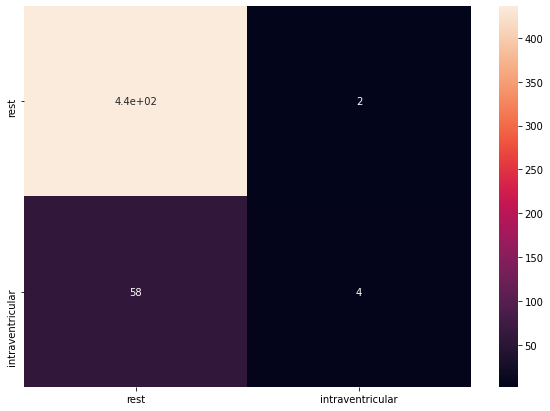

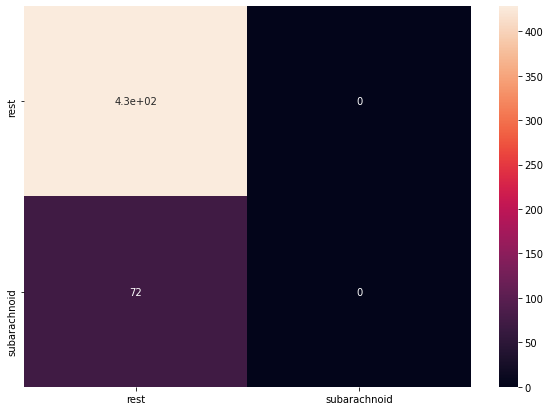

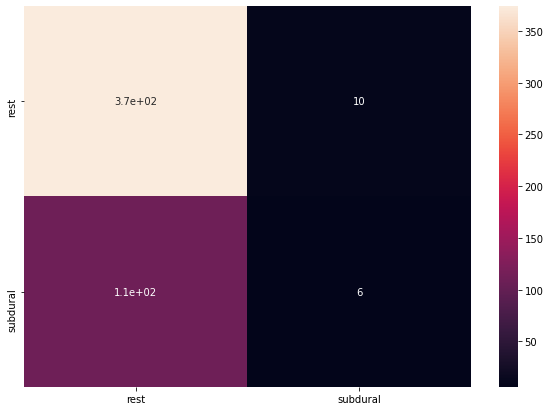

In [74]:
#one vs. rest
cm = multilabel_confusion_matrix(label_arr, pred_arr)
for idx, cm_i in enumerate(cm):
    clss = ['rest', CLASS_NAME[idx]]
    df_cm = pd.DataFrame(cm_i, index = [i for i in clss], columns = [i for i in clss])
    plt.figure(figsize = (10, 7))

    #plt.ylabel('True label')
    #plt.xlabel('Pred label')
    sn.heatmap(df_cm, annot=True)

## Validation with pre-trained model

In [76]:
save_path = './dense_ckpt01/'
net_pre = models.densenet161()
net_pre.features.conv0 = nn.Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
net_pre.classifier = nn.Sequential(nn.Linear(net_pre.classifier.in_features, 5), nn.Sigmoid())

net_pre.load_state_dict(torch.load(os.path.join(save_path, 'best_epoch.dat')))

<All keys matched successfully>

In [77]:
test_dataset = RSNAHemoDataset(dataset_tst,
                               default_loader = img_loader)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False,
                                          pin_memory=(torch.cuda.is_available()), num_workers=0)

In [78]:
h_score, output_arr, label_arr, pred_arr = test_acc(test_loader, net_pre, class_num=5)

100%|██████████| 32/32 [00:07<00:00,  4.23it/s]

Hamming score on the test images:  0.9133333333333332


In [79]:
CLASS_NAME = ["epidural", "intraparenchymal", "intraventricular", "subarachnoid", "subdural"]
print(metrics.classification_report(label_arr, pred_arr, target_names=CLASS_NAME))

                  precision    recall  f1-score   support

        epidural       1.00      0.90      0.95        10
intraparenchymal       0.94      0.93      0.93        80
intraventricular       0.92      0.95      0.94        62
    subarachnoid       0.81      0.76      0.79        72
        subdural       0.93      0.86      0.89       116

       micro avg       0.91      0.87      0.89       340
       macro avg       0.92      0.88      0.90       340
    weighted avg       0.91      0.87      0.89       340
     samples avg       0.44      0.42      0.43       340



In [80]:
from sklearn.metrics import multilabel_confusion_matrix

In [81]:
#confusion matrix : one vs rest
cm = multilabel_confusion_matrix(label_arr, pred_arr)
cm

array([[[490,   0],
        [  1,   9]],

       [[415,   5],
        [  6,  74]],

       [[433,   5],
        [  3,  59]],

       [[415,  13],
        [ 17,  55]],

       [[376,   8],
        [ 16, 100]]])

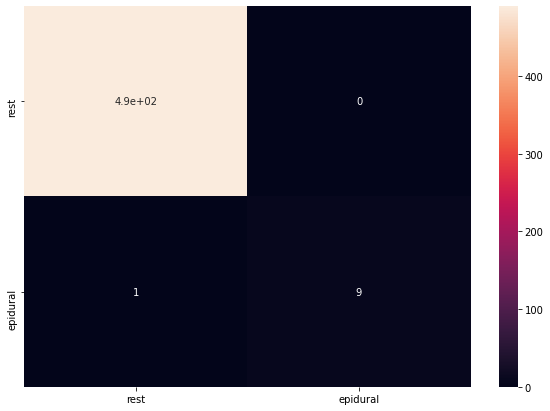

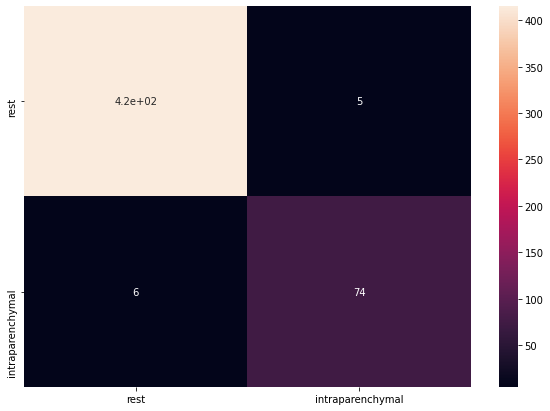

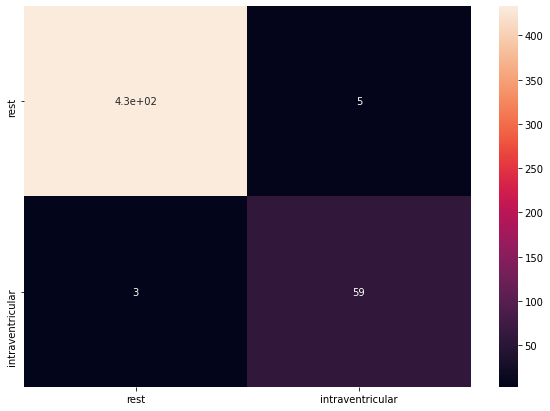

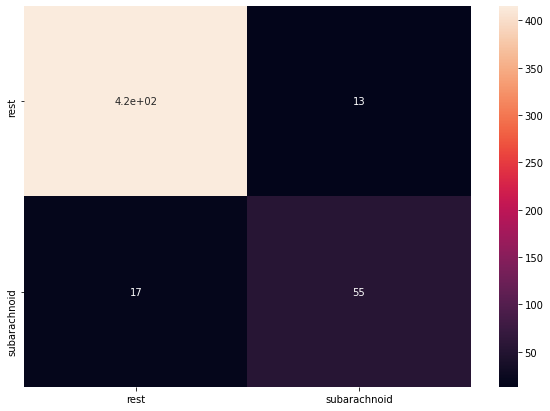

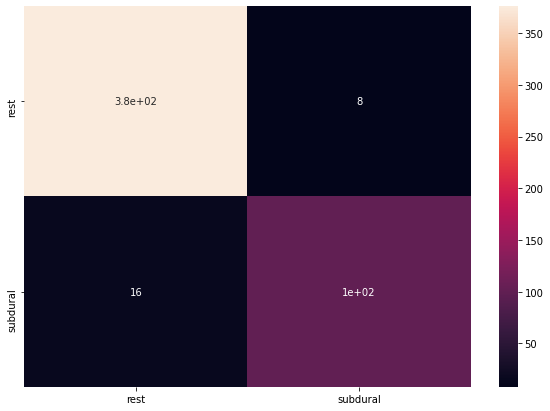

In [82]:
#one vs. rest
cm = multilabel_confusion_matrix(label_arr, pred_arr)
for idx, cm_i in enumerate(cm):
    clss = ['rest', CLASS_NAME[idx]]
    df_cm = pd.DataFrame(cm_i, index = [i for i in clss], columns = [i for i in clss])
    plt.figure(figsize = (10, 7))

    #plt.ylabel('True label')
    #plt.xlabel('Pred label')
    sn.heatmap(df_cm, annot=True)

In [83]:
# Grad-CAM
import cv2
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

![subtype](./sample/subtypes-of-hemorrhage.png)

In [ ]:
CLASS_NAME = ["epidural", "intraparenchymal", "intraventricular", "subarachnoid", "subdural"]

In [ ]:
#Intraventricular

In [99]:
N=52
image_path = np.array([dataset_tst[N],])#[dataset_tst[:,1]==1]

In [100]:
fname = os.path.splitext(os.path.basename(*image_path[:,0]))[0]
check_label = [[CLASS_NAME[idx]] for idx, ans in enumerate(label_arr[N]) if ans == 1.]
check_pred = [[CLASS_NAME[idx]] for idx, ans in enumerate(pred_arr[N]) if ans == 1.]
check_output = [[output_arr[N][idx]] for idx, ans in enumerate(pred_arr[N]) if ans == 1.]
print(f"Ground truth: {check_label}")
print(f"Prediction: {check_pred}")
print(f"Confidence: {check_output}")

Ground truth: [['intraventricular']]
Prediction: [['intraventricular']]
Confidence: [[0.999996542930603]]


In [101]:
input_img = img_loader(*image_path[:,0])
input_img = cv2.resize(input_img, (512, 512))
input_img = np.float32(input_img) / 255
rgb_img = np.array(Image.open(*image_path[:,0]).convert("RGB"))
rgb_img = cv2.resize(rgb_img, (512, 512))
rgb_img = np.float32(rgb_img) / 255

input_tensor = preprocess_image(input_img, mean=[0.5,], std=[0.5,])
target_layer = net_pre.features.norm5
cam = GradCAM(model=net_pre, target_layer=target_layer, use_cuda=True)
grayscale_cam = cam(input_tensor=input_tensor, target_category=None)
grayscale_cam = grayscale_cam[0, :]
cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

Text(0.5, 1.0, 'CAM')

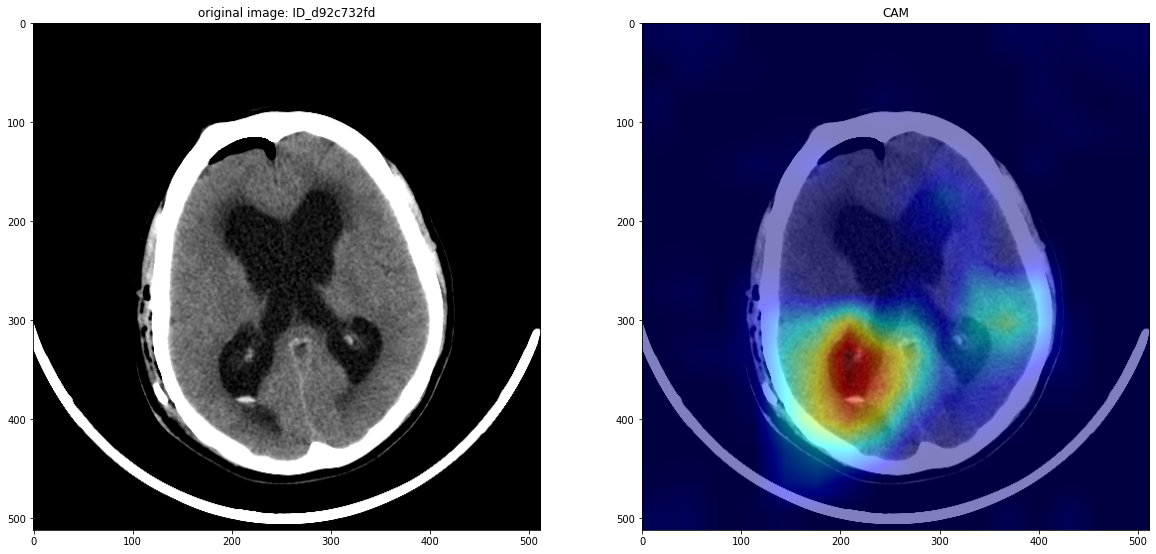

In [102]:
fig,ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(rgb_img, cmap='gray')
ax[0].set_title(f'original image: {fname}')
ax[1].imshow(cam_image)
ax[1].set_title('CAM')

In [140]:
#Intraparenchymal

In [141]:
N=109
image_path = np.array([dataset_tst[N],])#[dataset_tst[:,1]==1]

In [142]:
fname = os.path.splitext(os.path.basename(*image_path[:,0]))[0]
check_label = [[CLASS_NAME[idx]] for idx, ans in enumerate(label_arr[N]) if ans == 1.]
check_pred = [[CLASS_NAME[idx]] for idx, ans in enumerate(pred_arr[N]) if ans == 1.]
check_output = [[output_arr[N][idx]] for idx, ans in enumerate(pred_arr[N]) if ans == 1.]
print(f"Ground truth: {check_label}")
print(f"Prediction: {check_pred}")
print(f"Confidence: {check_output}")

Ground truth: [['intraparenchymal']]
Prediction: [['intraparenchymal']]
Confidence: [[0.9999945163726807]]


In [143]:
input_img = img_loader(*image_path[:,0])
input_img = cv2.resize(input_img, (512, 512))
input_img = np.float32(input_img) / 255
rgb_img = np.array(Image.open(*image_path[:,0]).convert("RGB"))
rgb_img = cv2.resize(rgb_img, (512, 512))
rgb_img = np.float32(rgb_img) / 255

input_tensor = preprocess_image(input_img, mean=[0.5,], std=[0.5,])
target_layer = net_pre.features.norm5
cam = GradCAM(model=net_pre, target_layer=target_layer, use_cuda=True)
grayscale_cam = cam(input_tensor=input_tensor, target_category=None)
grayscale_cam = grayscale_cam[0, :]
cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

Text(0.5, 1.0, 'CAM')

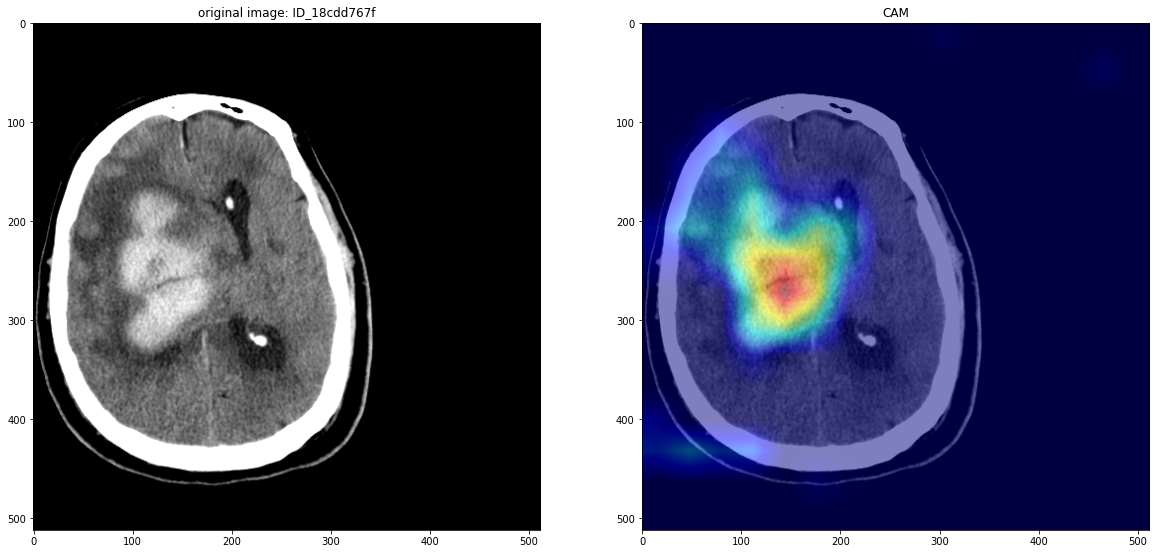

In [144]:
fig,ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(rgb_img, cmap='gray')
ax[0].set_title(f'original image: {fname}')
ax[1].imshow(cam_image)
ax[1].set_title('CAM')

In [165]:
N=132
image_path = np.array([dataset_tst[N],])#[dataset_tst[:,1]==1]

In [166]:
fname = os.path.splitext(os.path.basename(*image_path[:,0]))[0]
check_label = [[CLASS_NAME[idx]] for idx, ans in enumerate(label_arr[N]) if ans == 1.]
check_pred = [[CLASS_NAME[idx]] for idx, ans in enumerate(pred_arr[N]) if ans == 1.]
check_output = [[output_arr[N][idx]] for idx, ans in enumerate(pred_arr[N]) if ans == 1.]
print(f"Ground truth: {check_label}")
print(f"Prediction: {check_pred}")
print(f"Confidence: {check_output}")

Ground truth: [['intraparenchymal']]
Prediction: [['intraparenchymal']]
Confidence: [[0.9999998807907104]]


In [169]:
input_img = img_loader(*image_path[:,0])
input_img = cv2.resize(input_img, (512, 512))
input_img = np.float32(input_img) / 255
rgb_img = np.array(Image.open(*image_path[:,0]).convert("RGB"))
rgb_img = cv2.resize(rgb_img, (512, 512))
rgb_img = np.float32(rgb_img) / 255

input_tensor = preprocess_image(input_img, mean=[0.5,], std=[0.5,])
target_layer = net_pre.features.norm5
cam = GradCAM(model=net_pre, target_layer=target_layer, use_cuda=True)
grayscale_cam = cam(input_tensor=input_tensor, target_category=None)
grayscale_cam = grayscale_cam[0, :]
cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

Text(0.5, 1.0, 'CAM')

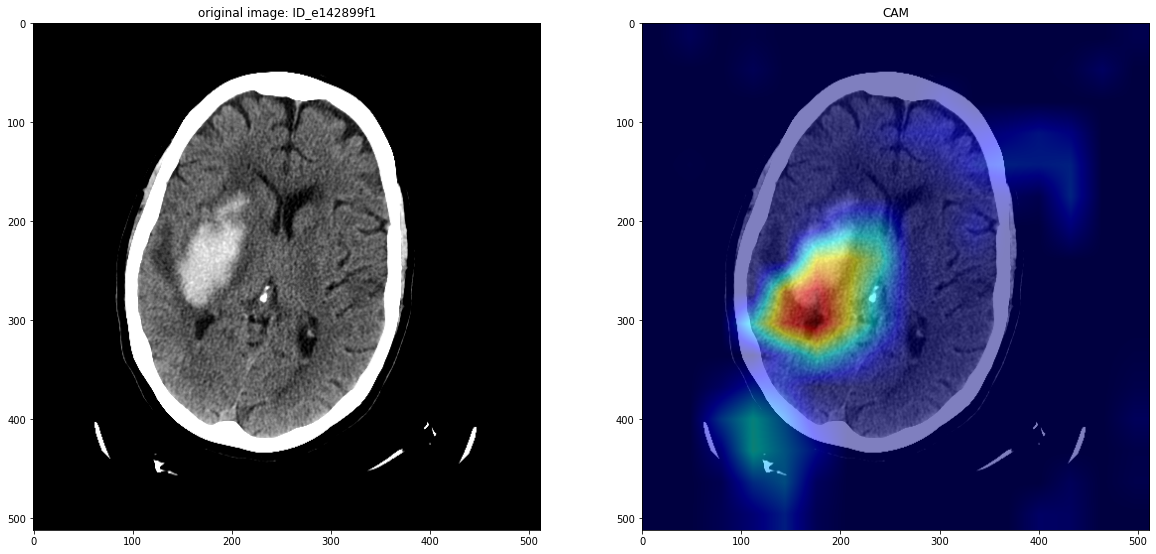

In [170]:
fig,ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(rgb_img, cmap='gray')
ax[0].set_title(f'original image: {fname}')
ax[1].imshow(cam_image)
ax[1].set_title('CAM')

In [ ]:
#Epidural and Subarachnoid

In [171]:
N=141
image_path = np.array([dataset_tst[N],])#[dataset_tst[:,1]==1]

In [172]:
fname = os.path.splitext(os.path.basename(*image_path[:,0]))[0]
check_label = [[CLASS_NAME[idx]] for idx, ans in enumerate(label_arr[N]) if ans == 1.]
check_pred = [[CLASS_NAME[idx]] for idx, ans in enumerate(pred_arr[N]) if ans == 1.]
check_output = [[output_arr[N][idx]] for idx, ans in enumerate(pred_arr[N]) if ans == 1.]
print(f"Ground truth: {check_label}")
print(f"Prediction: {check_pred}")
print(f"Confidence: {check_output}")

Ground truth: [['epidural'], ['subarachnoid']]
Prediction: [['epidural'], ['subarachnoid']]
Confidence: [[0.9999997615814209], [0.9999790191650391]]


In [173]:
input_img = img_loader(*image_path[:,0])
input_img = cv2.resize(input_img, (512, 512))
input_img = np.float32(input_img) / 255
rgb_img = np.array(Image.open(*image_path[:,0]).convert("RGB"))
rgb_img = cv2.resize(rgb_img, (512, 512))
rgb_img = np.float32(rgb_img) / 255

input_tensor = preprocess_image(input_img, mean=[0.5,], std=[0.5,])
target_layer = net_pre.features.norm5
cam = GradCAM(model=net_pre, target_layer=target_layer, use_cuda=True)
grayscale_cam = cam(input_tensor=input_tensor, target_category=4) #Epidural
grayscale_cam = grayscale_cam[0, :]
cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

Text(0.5, 1.0, 'CAM')

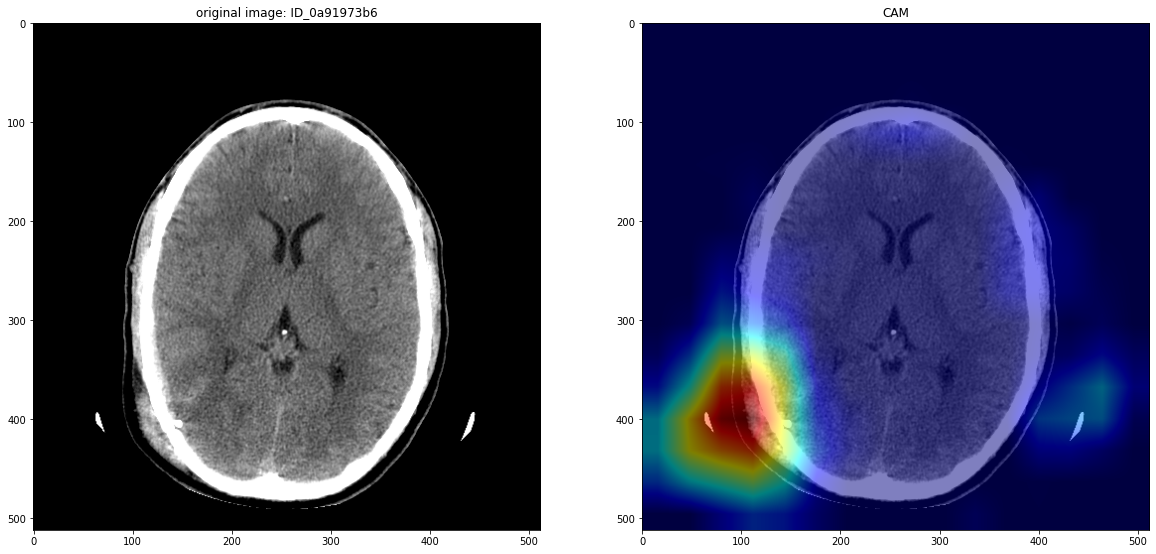

In [174]:
fig,ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(rgb_img, cmap='gray')
ax[0].set_title(f'original image: {fname}')
ax[1].imshow(cam_image)
ax[1].set_title('CAM')

In [176]:
input_img = img_loader(*image_path[:,0])
input_img = cv2.resize(input_img, (512, 512))
input_img = np.float32(input_img) / 255
rgb_img = np.array(Image.open(*image_path[:,0]).convert("RGB"))
rgb_img = cv2.resize(rgb_img, (512, 512))
rgb_img = np.float32(rgb_img) / 255

input_tensor = preprocess_image(input_img, mean=[0.5,], std=[0.5,])
target_layer = net_pre.features.norm5
cam = GradCAM(model=net_pre, target_layer=target_layer, use_cuda=True)
grayscale_cam = cam(input_tensor=input_tensor, target_category=2) #Subarachnoid
grayscale_cam = grayscale_cam[0, :]
cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

Text(0.5, 1.0, 'CAM')

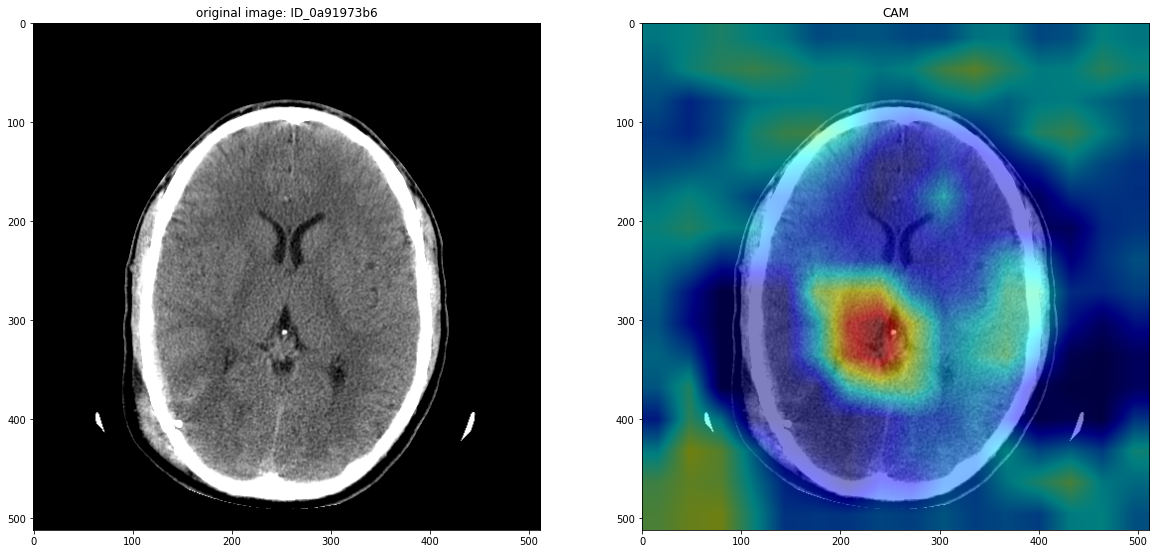

In [177]:
fig,ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(rgb_img, cmap='gray')
ax[0].set_title(f'original image: {fname}')
ax[1].imshow(cam_image)
ax[1].set_title('CAM')

In [182]:
#Subdural

In [183]:
N=162
image_path = np.array([dataset_tst[N],])#[dataset_tst[:,1]==1]

In [184]:
fname = os.path.splitext(os.path.basename(*image_path[:,0]))[0]
check_label = [[CLASS_NAME[idx]] for idx, ans in enumerate(label_arr[N]) if ans == 1.]
check_pred = [[CLASS_NAME[idx]] for idx, ans in enumerate(pred_arr[N]) if ans == 1.]
check_output = [[output_arr[N][idx]] for idx, ans in enumerate(pred_arr[N]) if ans == 1.]
print(f"Ground truth: {check_label}")
print(f"Prediction: {check_pred}")
print(f"Confidence: {check_output}")

Ground truth: [['subdural']]
Prediction: [['subdural']]
Confidence: [[0.9999977350234985]]


In [185]:
input_img = img_loader(*image_path[:,0])
input_img = cv2.resize(input_img, (512, 512))
input_img = np.float32(input_img) / 255
rgb_img = np.array(Image.open(*image_path[:,0]).convert("RGB"))
rgb_img = cv2.resize(rgb_img, (512, 512))
rgb_img = np.float32(rgb_img) / 255

input_tensor = preprocess_image(input_img, mean=[0.5,], std=[0.5,])
target_layer = net_pre.features.norm5
cam = GradCAM(model=net_pre, target_layer=target_layer, use_cuda=True)
grayscale_cam = cam(input_tensor=input_tensor, target_category=None)
grayscale_cam = grayscale_cam[0, :]
cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

Text(0.5, 1.0, 'CAM')

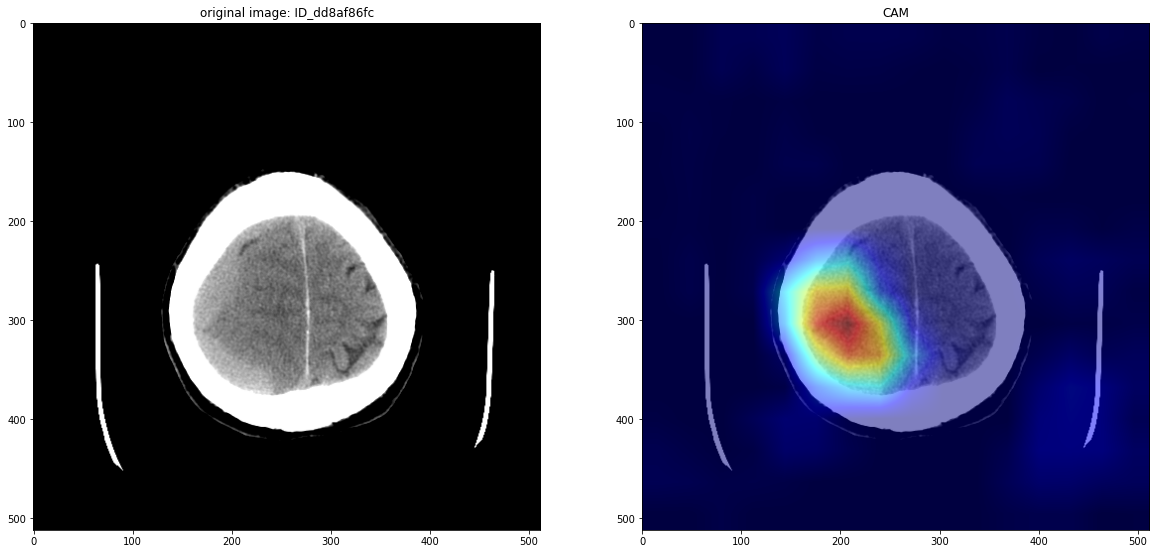

In [186]:
fig,ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(rgb_img, cmap='gray')
ax[0].set_title(f'original image: {fname}')
ax[1].imshow(cam_image)
ax[1].set_title('CAM')

In [182]:
#TruePositive: Intraparenchymal, Subdural
#FalsePositive: Subarachnoid

In [187]:
N=166
image_path = np.array([dataset_tst[N],])#[dataset_tst[:,1]==1]

In [188]:
fname = os.path.splitext(os.path.basename(*image_path[:,0]))[0]
check_label = [[CLASS_NAME[idx]] for idx, ans in enumerate(label_arr[N]) if ans == 1.]
check_pred = [[CLASS_NAME[idx]] for idx, ans in enumerate(pred_arr[N]) if ans == 1.]
check_output = [[output_arr[N][idx]] for idx, ans in enumerate(pred_arr[N]) if ans == 1.]
print(f"Ground truth: {check_label}")
print(f"Prediction: {check_pred}")
print(f"Confidence: {check_output}")

Ground truth: [['intraparenchymal'], ['subdural']]
Prediction: [['intraparenchymal'], ['subarachnoid'], ['subdural']]
Confidence: [[0.9982576966285706], [0.9730151891708374], [0.9653451442718506]]


In [199]:
input_img = img_loader(*image_path[:,0])
input_img = cv2.resize(input_img, (512, 512))
input_img = np.float32(input_img) / 255
rgb_img = np.array(Image.open(*image_path[:,0]).convert("RGB"))
rgb_img = cv2.resize(rgb_img, (512, 512))
rgb_img = np.float32(rgb_img) / 255

input_tensor = preprocess_image(input_img, mean=[0.5,], std=[0.5,])
target_layer = net_pre.features.norm5
cam = GradCAM(model=net_pre, target_layer=target_layer, use_cuda=True)
grayscale_cam = cam(input_tensor=input_tensor, target_category=1) #Intraparenchymal
grayscale_cam = grayscale_cam[0, :]
cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

Text(0.5, 1.0, 'CAM')

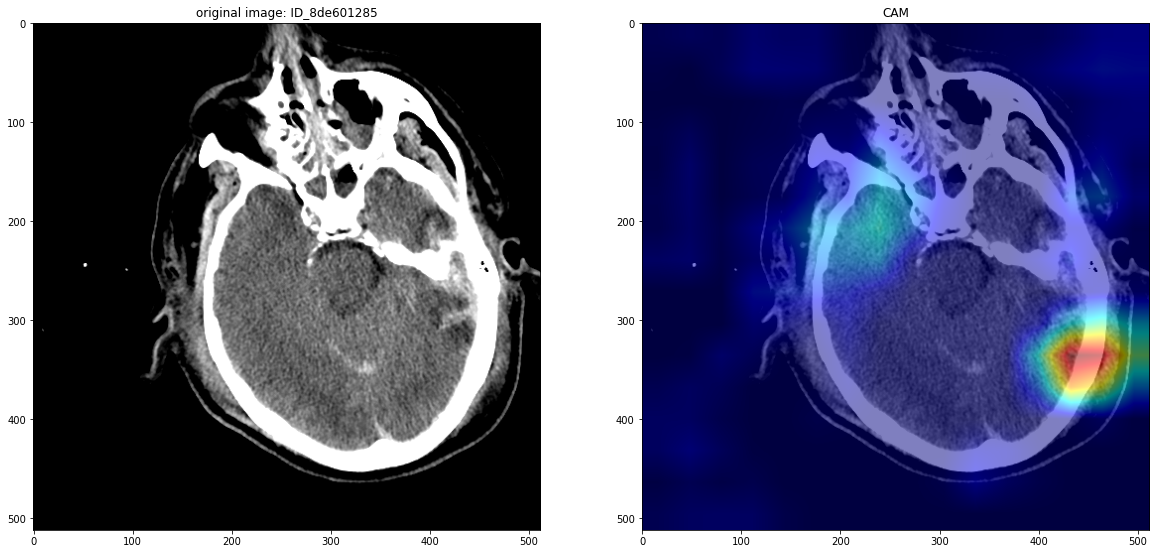

In [200]:
fig,ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(rgb_img, cmap='gray')
ax[0].set_title(f'original image: {fname}')
ax[1].imshow(cam_image)
ax[1].set_title('CAM')

In [201]:
input_img = img_loader(*image_path[:,0])
input_img = cv2.resize(input_img, (512, 512))
input_img = np.float32(input_img) / 255
rgb_img = np.array(Image.open(*image_path[:,0]).convert("RGB"))
rgb_img = cv2.resize(rgb_img, (512, 512))
rgb_img = np.float32(rgb_img) / 255

input_tensor = preprocess_image(input_img, mean=[0.5,], std=[0.5,])
target_layer = net_pre.features.norm5
cam = GradCAM(model=net_pre, target_layer=target_layer, use_cuda=True)
grayscale_cam = cam(input_tensor=input_tensor, target_category=4) #Intraparenchymal
grayscale_cam = grayscale_cam[0, :]
cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

Text(0.5, 1.0, 'CAM')

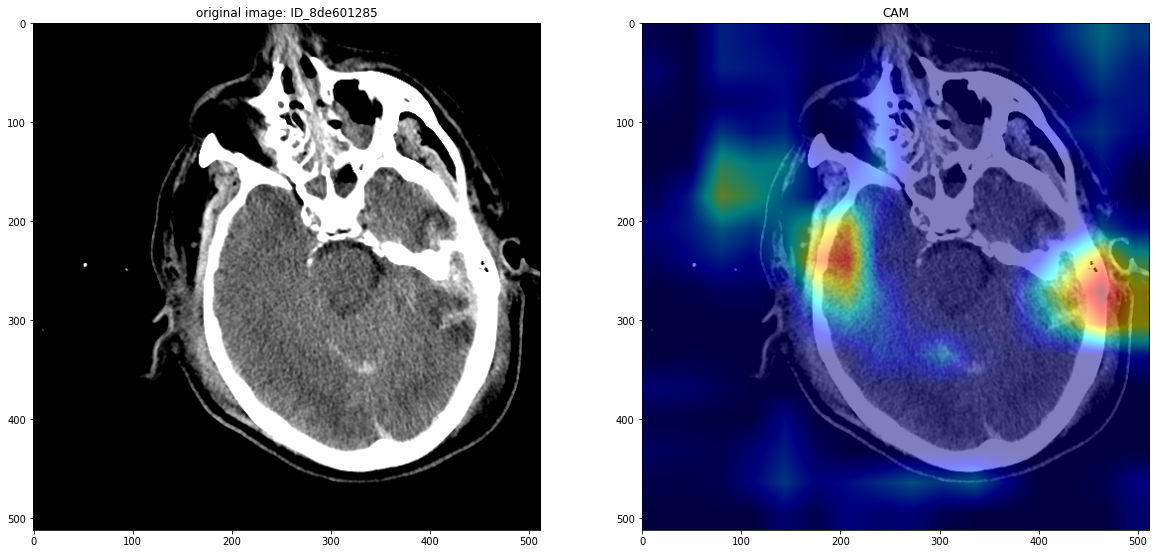

In [202]:
fig,ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(rgb_img, cmap='gray')
ax[0].set_title(f'original image: {fname}')
ax[1].imshow(cam_image)
ax[1].set_title('CAM')

In [204]:
input_img = img_loader(*image_path[:,0])
input_img = cv2.resize(input_img, (512, 512))
input_img = np.float32(input_img) / 255
rgb_img = np.array(Image.open(*image_path[:,0]).convert("RGB"))
rgb_img = cv2.resize(rgb_img, (512, 512))
rgb_img = np.float32(rgb_img) / 255

input_tensor = preprocess_image(input_img, mean=[0.5,], std=[0.5,])
target_layer = net_pre.features.norm5
cam = GradCAM(model=net_pre, target_layer=target_layer, use_cuda=True)
grayscale_cam = cam(input_tensor=input_tensor, target_category=3) #Subarachnoid(FalsePositive)
grayscale_cam = grayscale_cam[0, :]
cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

Text(0.5, 1.0, 'CAM')

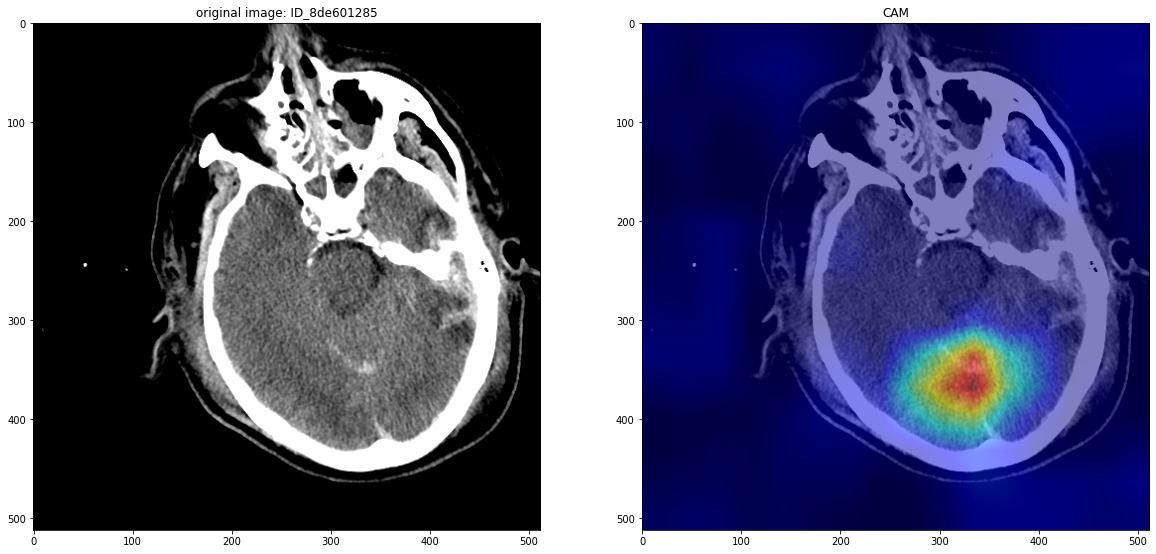

In [205]:
fig,ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(rgb_img, cmap='gray')
ax[0].set_title(f'original image: {fname}')
ax[1].imshow(cam_image)
ax[1].set_title('CAM')